## Importing the Required Libraries

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 5.0 MB/s eta 0:00:0000:01


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import time
import random
import collections
import cv2
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout, Rescaling
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization, AveragePooling2D
from collections import defaultdict
import keras.api._v2.keras as keras
from keras.applications import ResNet50V2, ResNet50, ResNet101, ResNet101V2, ResNet152, ResNet152V2, MobileNetV2, MobileNet, MobileNetV3Small, MobileNetV3Large, EfficientNetB0, EfficientNetV2S
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
import os
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
import tensorflow_model_optimization as tfmot

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
train_dir = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/"
test_dir = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/"
val_dir = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/"

print('num_of_classes: {} /'.format(len(os.listdir(train_dir))),'name_of_classes: {}'.format(os.listdir(train_dir)))
print('num_of_train_withoutmask {}/'.format(len(os.listdir(train_dir+'WithoutMask'))),'num_of_train_withmask {}'.format(len(os.listdir(train_dir+'WithMask'))))

print('num_of_test_withoutmask {}/'.format(len(os.listdir(test_dir+'WithoutMask'))),'num_of_test_withmask {}'.format(len(os.listdir(test_dir+'WithMask'))))
print('num_of_val_withoutmask {}/'.format(len(os.listdir(val_dir+'WithoutMask'))),'num_of_val_withmask {}'.format(len(os.listdir(val_dir+'WithMask'))))

num_of_classes: 2 / name_of_classes: ['WithoutMask', 'WithMask']
num_of_train_withoutmask 5000/ num_of_train_withmask 5000
num_of_test_withoutmask 509/ num_of_test_withmask 483
num_of_val_withoutmask 400/ num_of_val_withmask 400


In [6]:
h=128
w=128

train_datagen = ImageDataGenerator(width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   rescale=1./255,                                       
                                   rotation_range=10,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)


train_gen=train_datagen.flow_from_directory(train_dir,target_size=(h,w),batch_size=32,color_mode="rgb",class_mode='categorical')
test_gen=test_datagen.flow_from_directory( test_dir, target_size=(h,w), batch_size=32,color_mode="rgb",class_mode='categorical')
val_gen=val_datagen.flow_from_directory(val_dir,target_size=(h,w), batch_size=32,color_mode="rgb", class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


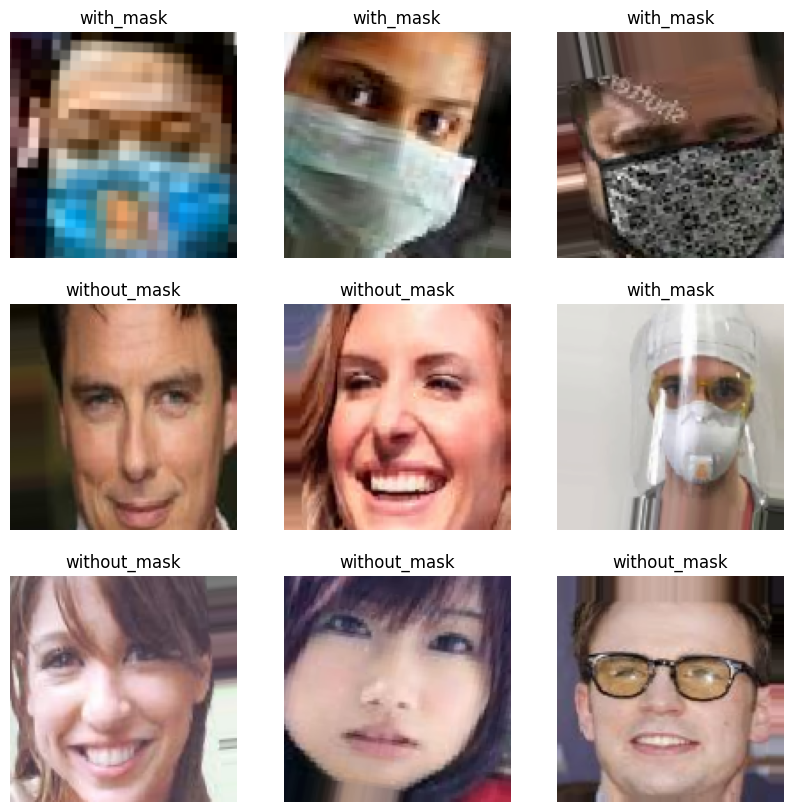

In [25]:
plt.figure(figsize=(10, 10))
for i in range(5):
    for i in range(9):
        a=random.randint(0,313)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(train_gen[a][0][0])
        plt.title('with_mask' if train_gen[a][1][0][0]==1 else 'without_mask')
        plt.axis("off")

In [8]:
ResNet_models={"ResNet50":ResNet50(include_top=False,input_shape=(128,128,3)),"ResNet101":ResNet101(include_top=False, input_shape=(128, 128, 3)),
              'ResNet152':ResNet152(include_top=False, input_shape=(128, 128, 3)),"ResNet50V2":ResNet50V2(include_top=False, input_shape=(128, 128, 3)),
              'ResNet101V2':ResNet101V2(include_top=False, input_shape=(128, 128, 3)),'ResNet152V2':ResNet152V2(include_top=False, input_shape=(128, 128, 3))}

234545216/234545216 [==============================] - 1s 0us/step


In [7]:
MobileNet_models = {"MobileNet":MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3)), 
                    "MobileNetV2":MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)), 
                    "MobileNetV3Small":MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
                    "MobileNetV3Large":MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(128, 128, 3))}

12683000/12683000 [==============================] - 0s 0us/step


In [28]:
def print_size(model):
    dtype_size = {'float32': 4, 'float16': 2, 'int8': 1}

    # Compute the approximate model size in bytes
    total_size = 0
    for layer in model.layers:
        for weight in layer.get_weights():
            weight_size = np.prod(weight.shape) * dtype_size[str(weight.dtype)]
            total_size += weight_size

    return total_size/(1024*1024)

## Model Sizes for MobileNet Models

In [29]:
model_size = pd.DataFrame(columns=['Model', 'Size (MB)'])
for model_name, model in MobileNet_models.items():
    model_size.loc[len(model_size), ['Model','Size (MB)']] = model_name, print_size(model)
model_size

,Model,Size (MB)
0,MobileNet,12.317139
1,MobileNetV2,8.613525
2,MobileNetV3Small,3.582458
3,MobileNetV3Large,11.430176


## Model Sizes for ResNet Models

In [30]:
model_size = pd.DataFrame(columns=['Model', 'Size (MB)'])
for model_name, model in ResNet_models.items():
    model_size.loc[len(model_size), ['Model','Size (MB)']] = model_name, print_size(model)
model_size

,Model,Size (MB)
0,ResNet50,89.97998
1,ResNet101,162.728027
2,ResNet152,222.66748
3,ResNet50V2,89.892578
4,ResNet101V2,162.607422
5,ResNet152V2,222.517578


The model sizes for MobileNet Model is much lesser then ResNet Model therefore MobileNet Models are much better choice compared to ResNet Models

## Training without Quantization Kernel Size 64 for Dense Layer

In [44]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [45]:
start=time.perf_counter()
all_models=[]
i=0
for model_ in MobileNet_models:
    print(model_)
    model_ = MobileNet_models[model_]
    for layer in model_.layers:
        layer.trainable=False

    model=Sequential()

    model.add(model_)

    model.add(Flatten())
    model.add(BatchNormalization(momentum=0.98))
    model.add(Dense(64,activation='relu', kernel_initializer="he_uniform"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="sigmoid"))


    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    Checkpoints = ModelCheckpoint(list(MobileNet_models.keys())[i]+".h5", monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


    Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 20,verbose = 1,
                                             restore_best_weights = True)
    callbacks=[Earlystop,Checkpoints]
    epochs=10
    train_numbers=10000
    valid_numbers=800
    all_models.append(model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,
                                   steps_per_epoch=train_numbers//64,validation_steps=valid_numbers//64))
    model.save(list(MobileNet_models.keys())[i]+".h5")
    i+=1

stop=time.perf_counter()

print('{:0.4f} mins elapsed'.format((stop-start)/60))


MobileNet


/tmp/ipykernel_31/3637685370.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  all_models.append(model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,


Epoch 1/10
156/156 [==============================] - 41s 246ms/step - loss: 0.0637 - accuracy: 0.9859 - val_loss: 0.0184 - val_accuracy: 0.9948
Epoch 2/10
156/156 [==============================] - 35s 226ms/step - loss: 0.0265 - accuracy: 0.9942 - val_loss: 8.5824e-04 - val_accuracy: 1.0000
Epoch 3/10
156/156 [==============================] - 31s 201ms/step - loss: 0.0256 - accuracy: 0.9956 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/10
156/156 [==============================] - 31s 197ms/step - loss: 0.0250 - accuracy: 0.9952 - val_loss: 0.0210 - val_accuracy: 0.9922
Epoch 5/10
156/156 [==============================] - 30s 193ms/step - loss: 0.0232 - accuracy: 0.9950 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/10
156/156 [==============================] - 31s 196ms/step - loss: 0.0236 - accuracy: 0.9946 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
156/156 [==============================] - 31s 200ms/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0020 - va

In [46]:
test_losses = []
test_accs= []
for model_ in MobileNet_models:
    model = keras.models.load_model("/kaggle/working/"+model_ + ".h5")
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
np.save('no_quant_test_loss_64kernel.npy',np.array(test_losses))
np.save('no_quant_test_acc_64kernel.npy',np.array(test_accs))
    
    

31/31 [==============================] - 3s 70ms/step - loss: 0.1396 - accuracy: 0.9506


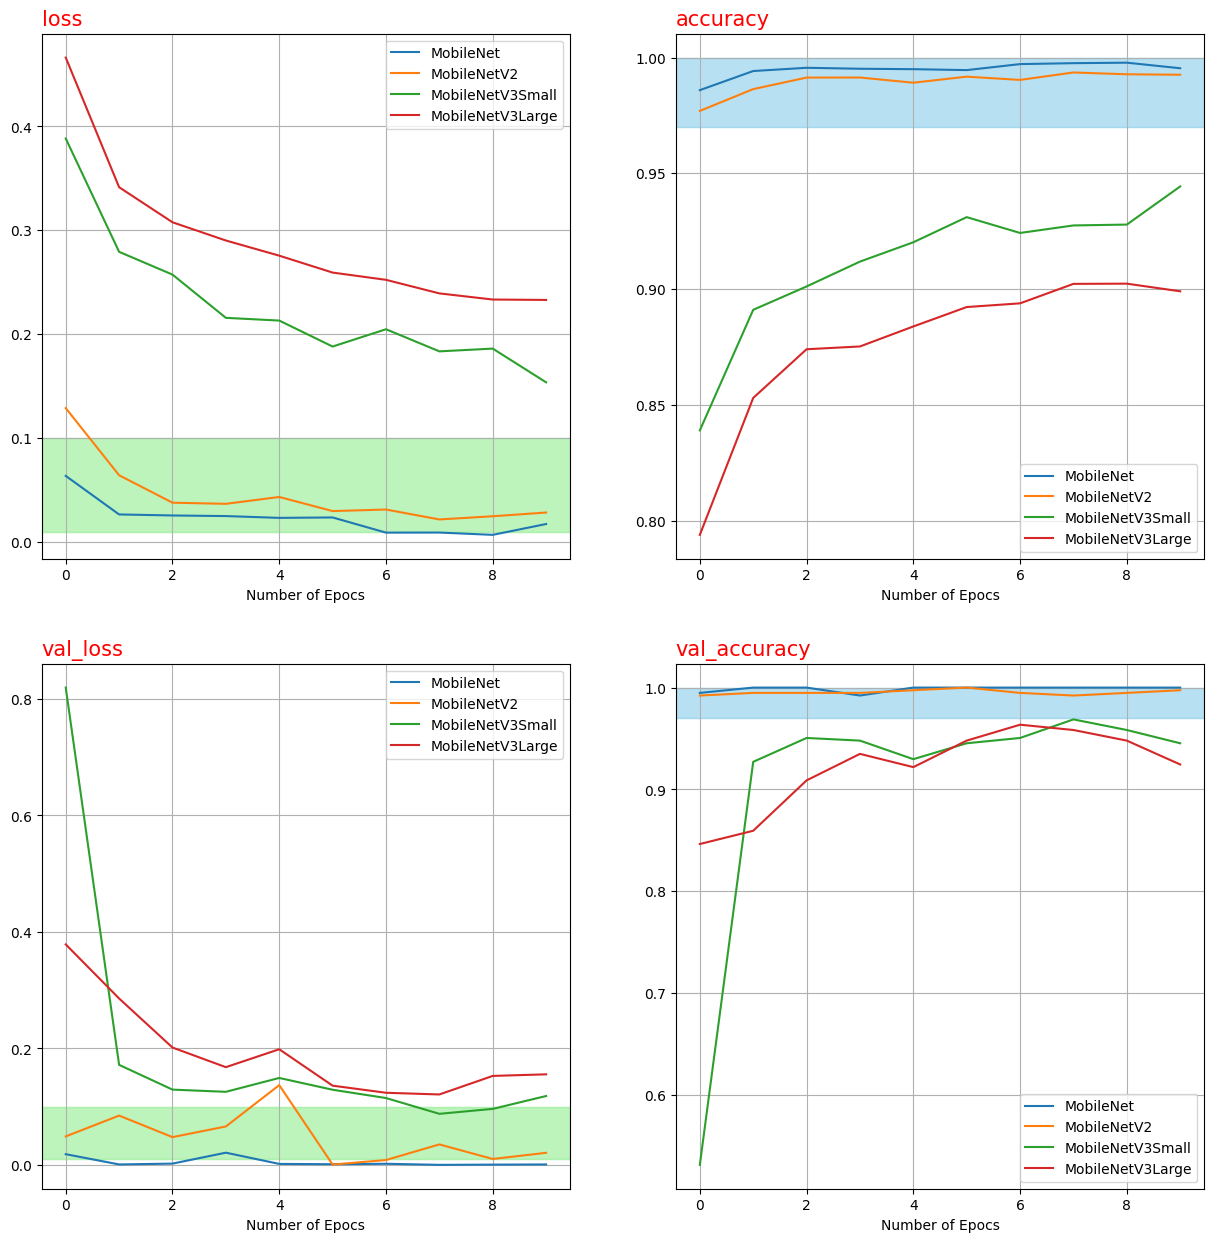

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i,value in enumerate(all_models[0].history):
    ax = axes.flatten()[i]
    lab=0
    for history in all_models:
        label=list(MobileNet_models)[lab]
        ax.plot(history.history[value],label=label)
        if value=="accuracy" or value=="val_accuracy":
            ax.axhspan(0.97,1,color="skyblue",alpha=0.2)
        elif value=="loss" or value=="val_loss":
            ax.axhspan(0.1,0.01,color="lightgreen",alpha=0.2)
        lab += 1
    ax.set_title(value,size=15, color="r",loc="left")
    ax.legend()
    ax.set_xlabel("Number of Epocs")
    ax.grid()
fig.savefig('with64KernelDenseLayer.png')
plt.show()


In [16]:
MobileNet_models = {"MobileNet":MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3)), 
                    "MobileNetV2":MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)), 
                    "MobileNetV3Small":MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
                    "MobileNetV3Large":MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(128, 128, 3))}

12683000/12683000 [==============================] - 0s 0us/step


## Training without Quantization Kernel Size 128 for Dense Layer 

In [60]:
start=time.perf_counter()
all_models=[]

i=0
for model_ in MobileNet_models:
    print(model_)
    model_ = MobileNet_models[model_]
    for layer in model_.layers:
        layer.trainable=False

    model=Sequential()

    model.add(model_)

    model.add(Flatten())
    model.add(BatchNormalization(momentum=0.98))
    model.add(Dense(128,activation='relu', kernel_initializer="he_uniform"))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation="sigmoid"))
   

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    Checkpoints = ModelCheckpoint(list(MobileNet_models.keys())[i]+".h5", monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


    Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 20,verbose = 1,
                                             restore_best_weights = True)
    callbacks=[Earlystop,Checkpoints]
    epochs=10
    train_numbers=10000
    valid_numbers=800
    all_models.append(model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,
                                   steps_per_epoch=train_numbers//64,validation_steps=valid_numbers//64))
    
    model.save(list(MobileNet_models.keys())[i]+".h5")
    i+=1
  
stop=time.perf_counter()

print('{:0.4f} mins elapsed'.format((stop-start)/60))


MobileNet


/tmp/ipykernel_31/2525726623.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  all_models.append(model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,


Epoch 1/10
156/156 [==============================] - 34s 200ms/step - loss: 0.0796 - accuracy: 0.9857 - val_loss: 0.0112 - val_accuracy: 0.9974
Epoch 2/10
156/156 [==============================] - 30s 195ms/step - loss: 0.0573 - accuracy: 0.9912 - val_loss: 0.0045 - val_accuracy: 0.9974
Epoch 3/10
156/156 [==============================] - 30s 195ms/step - loss: 0.0295 - accuracy: 0.9930 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/10
156/156 [==============================] - 31s 196ms/step - loss: 0.0281 - accuracy: 0.9950 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 5/10
156/156 [==============================] - 30s 192ms/step - loss: 0.0242 - accuracy: 0.9966 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
156/156 [==============================] - 30s 191ms/step - loss: 0.0185 - accuracy: 0.9960 - val_loss: 0.0178 - val_accuracy: 0.9974
Epoch 7/10
156/156 [==============================] - 30s 191ms/step - loss: 0.0146 - accuracy: 0.9974 - val_loss: 0.0120 - val_ac

In [63]:
test_losses = []
test_accs= []
for model_ in MobileNet_models:
    model = keras.models.load_model("/kaggle/working/"+model_ + ".h5")
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
np.save('no_quant_test_loss_128kernel.npy',np.array(test_losses))
np.save('no_quant_test_acc_128kernel.npy',np.array(test_accs))
    
    

31/31 [==============================] - 3s 71ms/step - loss: 0.1439 - accuracy: 0.9456


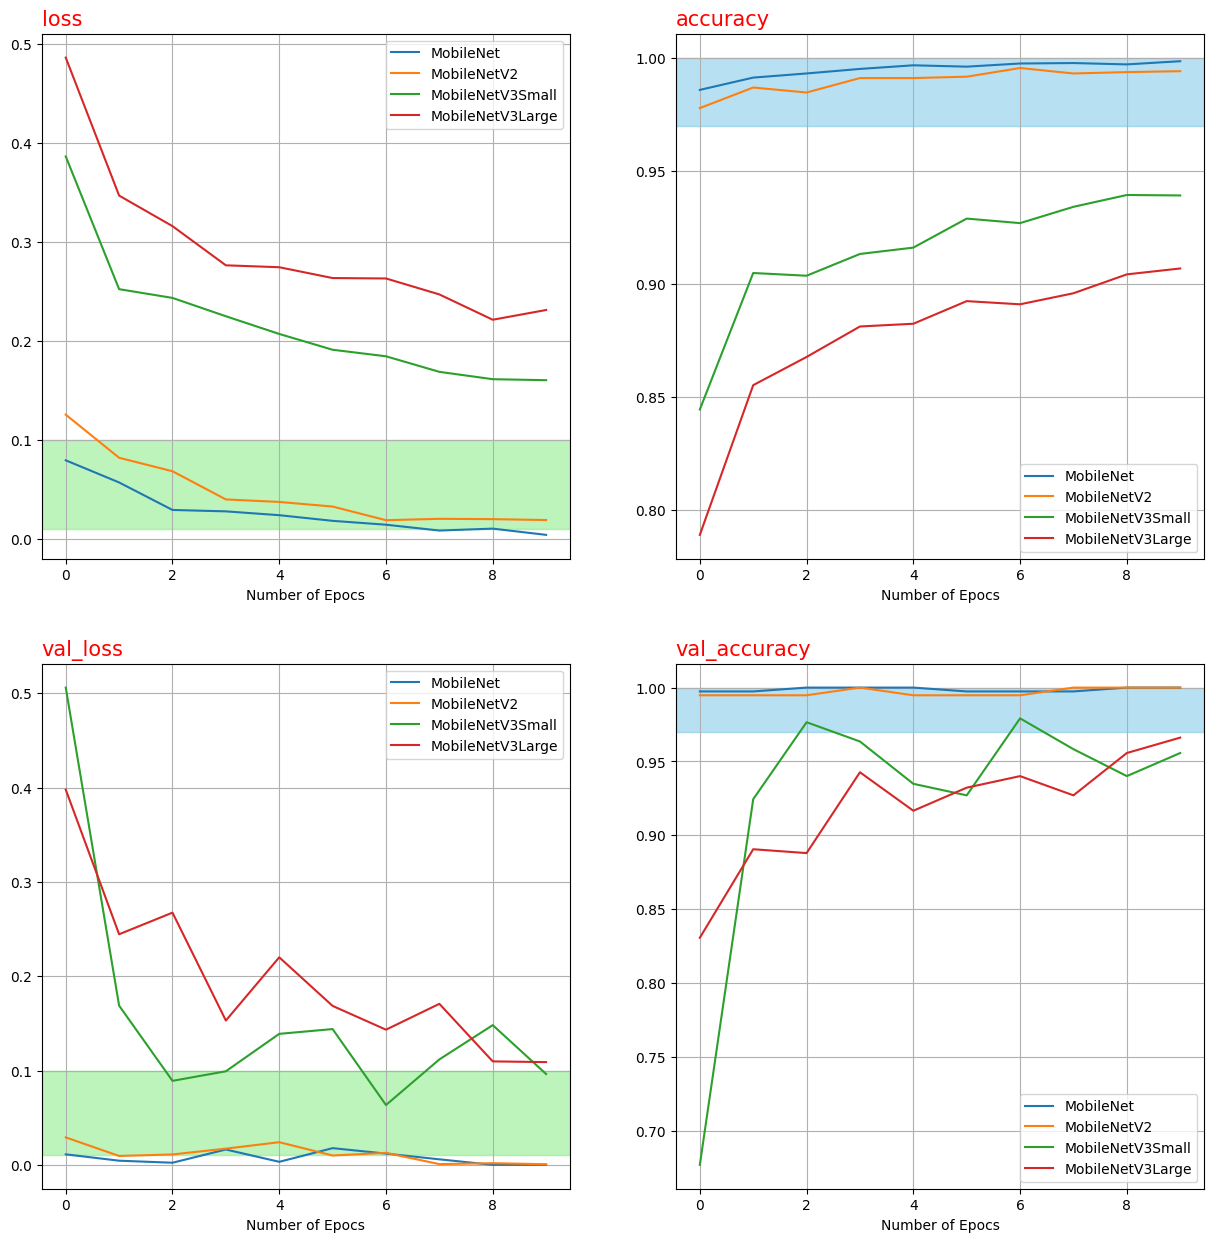

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i,value in enumerate(all_models[0].history):
    ax = axes.flatten()[i]
    lab=0
    for history in all_models:
        label=list(MobileNet_models)[lab]
        ax.plot(history.history[value],label=label)
        if value=="accuracy" or value=="val_accuracy":
            ax.axhspan(0.97,1,color="skyblue",alpha=0.2)
        elif value=="loss" or value=="val_loss":
            ax.axhspan(0.1,0.01,color="lightgreen",alpha=0.2)
        lab += 1
    ax.set_title(value,size=15, color="r",loc="left")
    ax.legend()
    ax.set_xlabel("Number of Epocs")
    ax.grid()
fig.savefig('with128KernelDenseLayer.png')
plt.show()


## No Dense Layer

In [164]:
MobileNet_models = {"MobileNet":MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3)), 
                    "MobileNetV2":MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3)), 
                    "MobileNetV3Small":MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
                    "MobileNetV3Large":MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(128, 128, 3))}

In [81]:
start=time.perf_counter()
all_models=[]

i=0
for model_ in MobileNet_models:
    print(model_)
    model_ = MobileNet_models[model_]
    for layer in model_.layers:
        layer.trainable=False

    model=Sequential()

    model.add(model_)

    model.add(Flatten())
    model.add(BatchNormalization(momentum=0.98))
    model.add(Dense(2,activation="sigmoid"))
   

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    Checkpoints = ModelCheckpoint(list(MobileNet_models.keys())[i]+".h5", monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


    Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5,verbose = 1,
                                             restore_best_weights = True)
    callbacks=[Earlystop,Checkpoints]
    epochs=15
    train_numbers=10000
    valid_numbers=800
    all_models.append(model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,
                                   steps_per_epoch=train_numbers//64,validation_steps=valid_numbers//64))
    
    model.save(list(MobileNet_models.keys())[i]+".h5")
    i+=1
  
stop=time.perf_counter()

print('{:0.4f} mins elapsed'.format((stop-start)/60))


MobileNet


/tmp/ipykernel_31/137222370.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  all_models.append(model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,


Epoch 1/15
156/156 [==============================] - 81s 504ms/step - loss: 0.0469 - accuracy: 0.9869 - val_loss: 8.1839e-04 - val_accuracy: 1.0000
Epoch 2/15
156/156 [==============================] - 31s 197ms/step - loss: 0.0316 - accuracy: 0.9926 - val_loss: 1.7727e-04 - val_accuracy: 1.0000
Epoch 3/15
156/156 [==============================] - 30s 193ms/step - loss: 0.0142 - accuracy: 0.9952 - val_loss: 3.8942e-04 - val_accuracy: 1.0000
Epoch 4/15
156/156 [==============================] - 30s 191ms/step - loss: 0.0197 - accuracy: 0.9948 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/15
156/156 [==============================] - 31s 196ms/step - loss: 0.0316 - accuracy: 0.9930 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 6/15
156/156 [==============================] - 30s 194ms/step - loss: 0.0153 - accuracy: 0.9966 - val_loss: 6.4621e-04 - val_accuracy: 1.0000
Epoch 7/15
156/156 [==============================] - 31s 196ms/step - loss: 0.0174 - accuracy: 0.9962 - val_loss:

In [82]:
test_losses = []
test_accs= []
for model_ in MobileNet_models:
    model = keras.models.load_model("/kaggle/working/"+model_ + ".h5")
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
np.save('no_quant_test_loss_no_dense_layer.npy',np.array(test_losses))
np.save('no_quant_test_acc_no_dense_layer.npy',np.array(test_accs))
    

31/31 [==============================] - 3s 68ms/step - loss: 0.1610 - accuracy: 0.9385


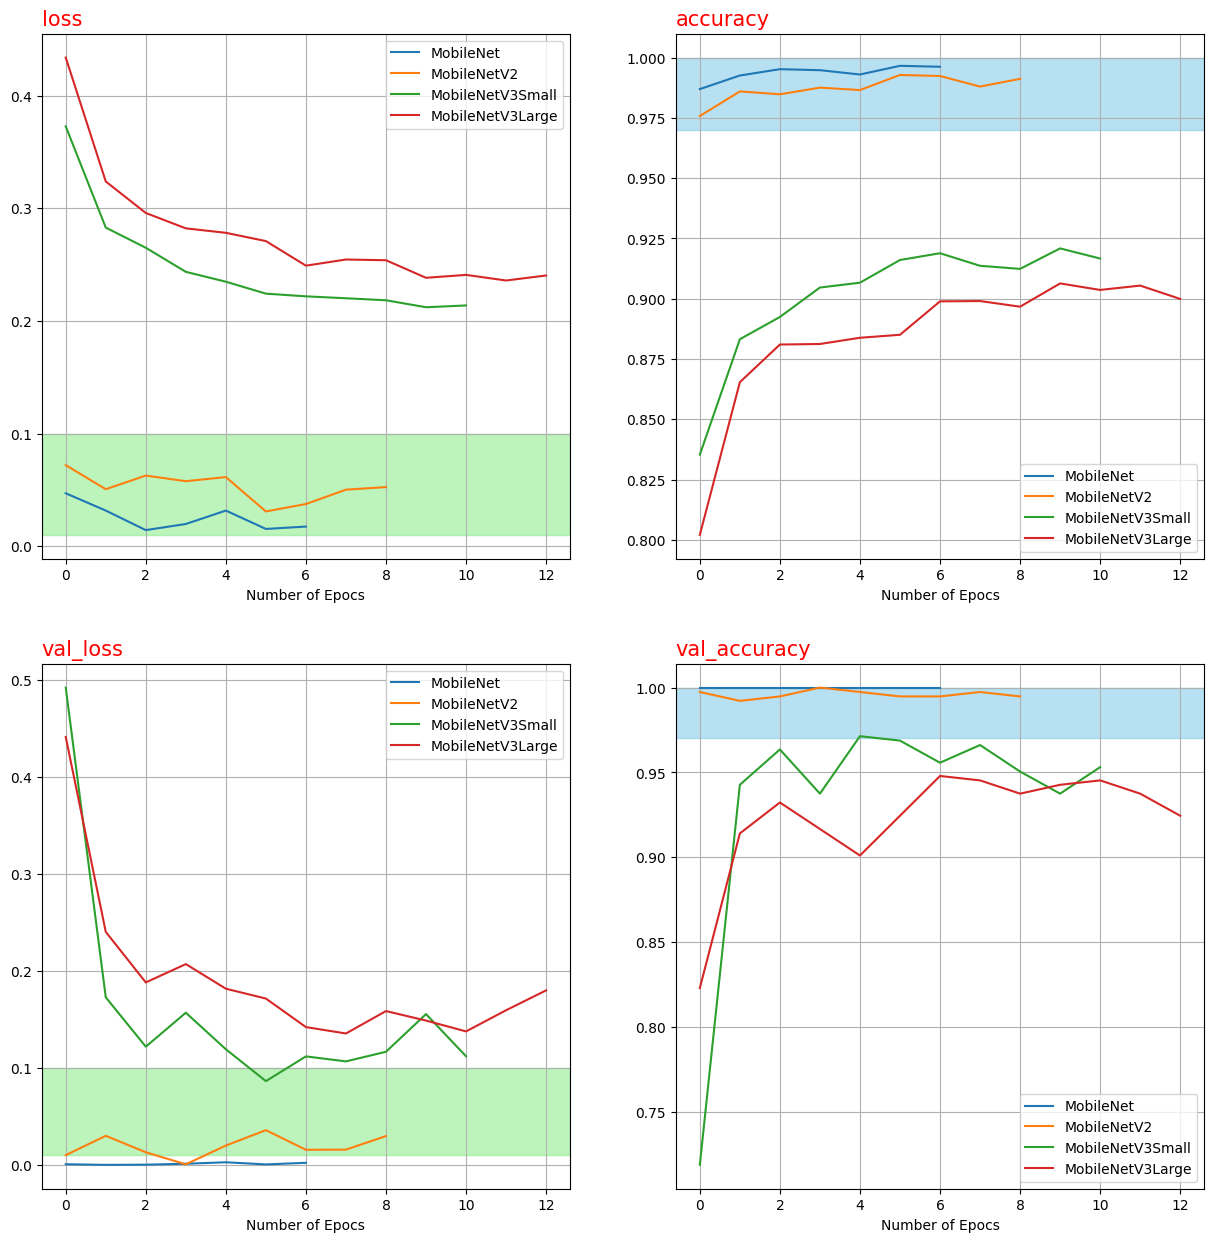

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i,value in enumerate(all_models[0].history):
    ax = axes.flatten()[i]
    lab=0
    for history in all_models:
        label=list(MobileNet_models)[lab]
        ax.plot(history.history[value],label=label)
        if value=="accuracy" or value=="val_accuracy":
            ax.axhspan(0.97,1,color="skyblue",alpha=0.2)
        elif value=="loss" or value=="val_loss":
            ax.axhspan(0.1,0.01,color="lightgreen",alpha=0.2)
        lab += 1
    ax.set_title(value,size=15, color="r",loc="left")
    ax.legend()
    ax.set_xlabel("Number of Epocs")
    ax.grid()
fig.savefig('with_no_DenseLayer.png')
plt.show()


## Model Pruning

In [27]:
model_ = MobileNet_models["MobileNetV2"]
for layer in model_.layers:
    layer.trainable=False

model=Sequential()

model.add(model_)

model.add(Flatten())
model.add(BatchNormalization(momentum=0.98))
model.add(Dense(128,activation='relu', kernel_initializer="he_uniform"))
model.add(Dropout(0.2))
model.add(BatchNormalization(momentum=0.98))
model.add(Dense(64,activation='relu', kernel_initializer="he_uniform"))
model.add(Dropout(0.2))
model.add(Dense(2,activation="sigmoid"))

In [29]:
batch_size = 64
epochs = 10
validation_split = 0.1 # 10% of training set will be used for validation set. 
train_images =10000
num_images = train_images * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.00,
                                                             final_sparsity=0.75,
                                                             begin_step=0,
                                                             end_step=end_step)
}

model = prune_low_magnitude(model, **pruning_params)

model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics=['accuracy'])
Checkpoints = ModelCheckpoint("pruned_model.h5", monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5,verbose = 1,
                                         restore_best_weights = True)
callbacks=[Earlystop,Checkpoints]
epochs=15
train_numbers=10000
valid_numbers=800
history = model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,
                               steps_per_epoch=train_numbers//64,validation_steps=valid_numbers//64)

model.save("pruned_model.h5")


/tmp/ipykernel_31/1638519011.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,


Epoch 1/15
156/156 [==============================] - 68s 229ms/step - loss: 0.1734 - accuracy: 0.9305 - val_loss: 0.0604 - val_accuracy: 0.9766
Epoch 2/15
156/156 [==============================] - 34s 218ms/step - loss: 0.1086 - accuracy: 0.9618 - val_loss: 0.0224 - val_accuracy: 0.9948
Epoch 3/15
156/156 [==============================] - 33s 212ms/step - loss: 0.0986 - accuracy: 0.9641 - val_loss: 0.0499 - val_accuracy: 0.9844
Epoch 4/15
156/156 [==============================] - 33s 211ms/step - loss: 0.0890 - accuracy: 0.9682 - val_loss: 0.0386 - val_accuracy: 0.9896
Epoch 5/15
156/156 [==============================] - 34s 215ms/step - loss: 0.0767 - accuracy: 0.9732 - val_loss: 0.0594 - val_accuracy: 0.9896
Epoch 6/15
156/156 [==============================] - 34s 215ms/step - loss: 0.2142 - accuracy: 0.9198 - val_loss: 0.7826 - val_accuracy: 0.6849
Epoch 7/15
156/156 [==============================] - 34s 218ms/step - loss: 0.1898 - accuracy: 0.9293 - val_loss: 0.1276 - val_ac

In [169]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       6369411   
 nal)                                                            
                                                                 
 prune_low_magnitude_flatten  (None, 16384)            1         
 _18 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_batch_n  (None, 16384)            65537     
 ormalization_18 (PruneLowMa                                     
 gnitude)                                                        
                                                                 
 prune_low_magnitude_dense_3  (None, 2)                65540     
 3 (PruneLowMagnitude)                                           
                                                     

## Post Training Quantization

In [143]:
model = keras.models.load_model("/kaggle/input/mobilenet/MobileNet (1).h5")

In [146]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 16384)             0         
                                                                 
 batch_normalization_18 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 2)                 32770     
                                                                 
Total params: 3,327,170
Trainable params: 65,538
Non-trainable params: 3,261,632
_________________________________________________________________


In [96]:
import glob
import os,sys
import numpy as np
import tensorflow as tf
import time
from PIL import Image

norm_type="n1to1"
quant_dir="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"

def representative_data_gen():
    files = glob.glob(quant_dir+'/**',recursive=True)
    valid_files = []
    valid_format = [".jpg", ".jpeg", ".png", ".bmp", ".ppm", ".pgm"]
    for name in files:
        ext = os.path.splitext(name)[1].lower()
        if ext not in valid_format:
            continue
        valid_files.append(os.path.join(quant_dir, name))
    if len(valid_files) == 0:
        raise Exception("No valid files in quant_input dir {}, support format{}: ".format(quant_dir, valid_format))
    print(str(len(valid_files))+"pics")
    for path in valid_files:
        img = Image.open(path)
        img = img.resize((w,h))
        img = np.array(img).astype(np.float32)
        shape = img.shape
        if len(shape) == 2:
            continue 
            shape = (1, shape[0], shape[1], 1)
        else:
            if(shape[2]!=3):
                continue
            shape = (1, shape[0], shape[1], shape[2])
        img = img.reshape(shape)
        if norm_type is not None:
            if norm_type == "0to1":
                img = img/255.0
            elif norm_type == "n1to1":
                img = (img-128)/128
            else:
                raise Exception("Unsupported norm_type: {}".format(norm_type))
#         print(img.shape)
#         print(path)
        yield [img]

## Full Integer Quantization

In [150]:
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
tflite_converter.representative_dataset = representative_data_gen
tflite_converter.inference_input_type = tf.float32
tflite_converter.inference_output_type = tf.float32
tflite_model = tflite_converter.convert()

/opt/conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


800pics


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [151]:
with open('mobilenet1.tflite', 'wb') as f:
    f.write(tflite_model)
f.close()

In [154]:
interpreter = tf.lite.Interpreter(model_path = "/kaggle/working/mobilenet1.tflite")
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 128 128   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [155]:
all_detail = interpreter.get_tensor_details()
for layer in all_detail:
    print(layer['dtype'])

<class 'numpy.float32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 'numpy.int8'>
<class 'numpy.int32'>
<class 

In [156]:
def get_data(dir):
    images = []
    for root, dirs, files in os.walk(dir):
        for filename in files:
            path = os.path.join(root, filename)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            img = img.astype(np.float32)
            img = img / 255.

            images.append(img)
    return np.array(images)
images = get_data(val_dir)

In [157]:
interpreter.resize_tensor_input(input_details[0]['index'], (len(images), 128, 128, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (len(images), 2))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [800 128 128   3]
Input Type: <class 'numpy.float32'>
Output Shape: [800   2]
Output Type: <class 'numpy.float32'>


In [159]:
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmin(tflite_model_predictions, axis=1)

Prediction results shape: (800, 2)


In [14]:
model_ = MobileNet_models["MobileNetV3Small"]
for layers in model_.layers:
    layers.trainable = False
model=Sequential()

model.add(model_)

model.add(Flatten())
model.add(BatchNormalization(momentum=0.98))
model.add(Dense(2,activation="sigmoid"))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
Checkpoints = ModelCheckpoint("1.h5", monitor='val_loss', verbose=0, save_best_only=True, mode='min', save_freq='epoch')


Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 15,verbose = 1,
                                         restore_best_weights = True)
callbacks=[Earlystop,Checkpoints]
epochs=30
train_numbers=10000
valid_numbers=800
history = model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,
                               steps_per_epoch=train_numbers//64,validation_steps=valid_numbers//64)

/tmp/ipykernel_31/1259237720.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,validation_data=val_gen,epochs=epochs,callbacks=callbacks,


Epoch 1/30
156/156 [==============================] - 76s 433ms/step - loss: 0.3737 - accuracy: 0.8317 - val_loss: 0.4523 - val_accuracy: 0.8099
Epoch 2/30
156/156 [==============================] - 46s 297ms/step - loss: 0.2853 - accuracy: 0.8846 - val_loss: 0.2199 - val_accuracy: 0.8984
Epoch 3/30
156/156 [==============================] - 38s 246ms/step - loss: 0.2627 - accuracy: 0.8965 - val_loss: 0.1398 - val_accuracy: 0.9453
Epoch 4/30
156/156 [==============================] - 33s 214ms/step - loss: 0.2463 - accuracy: 0.9015 - val_loss: 0.1422 - val_accuracy: 0.9401
Epoch 5/30
156/156 [==============================] - 30s 190ms/step - loss: 0.2499 - accuracy: 0.8973 - val_loss: 0.1339 - val_accuracy: 0.9531
Epoch 6/30
156/156 [==============================] - 30s 189ms/step - loss: 0.2313 - accuracy: 0.9097 - val_loss: 0.1078 - val_accuracy: 0.9635
Epoch 7/30
156/156 [==============================] - 29s 183ms/step - loss: 0.2146 - accuracy: 0.9196 - val_loss: 0.1099 - val_ac

In [ ]:
model.save("1.h5")